## Energy curve estimation 

The previous notebook contains some bad practive when trying to preduct timeseries data. Lets see if we can do better job using SARIMAX

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.eval_measures import rmse
from pmdarima import auto_arima
from scipy.signal import welch

#For some reason these don't work well on this dataset
from statsmodels.graphics.tsaplots import month_plot, quarter_plot 

#These are for testing for stationarity and causation
from statsmodels.tsa.stattools import adfuller,grangercausalitytests

%matplotlib inline

In [3]:
#Useful function to conduct the test and return output

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [4]:
df = pd.read_csv('equity_RN628A_hbase_data.csv',header=1,
                 names=['datetime','power','temperature','date','time','dow','month'],parse_dates=True,index_col=0)

In [4]:
df.head()

,power,temperature,date,time,dow,month
datetime,,,,,,
2012-11-01 08:15:00,NaN,NaN,2012-11-01,01:15:00,3,11
2012-11-01 08:30:00,NaN,NaN,2012-11-01,01:30:00,3,11
2012-11-01 08:45:00,NaN,NaN,2012-11-01,01:45:00,3,11
2012-11-01 09:00:00,NaN,60.1,2012-11-01,02:00:00,3,11
2012-11-01 09:15:00,NaN,60.8,2012-11-01,02:15:00,3,11


In [5]:
df.isna().sum()/len(df)

power          0.166755
temperature    0.729562
date           0.000000
time           0.000000
dow            0.000000
month          0.000000
dtype: float64

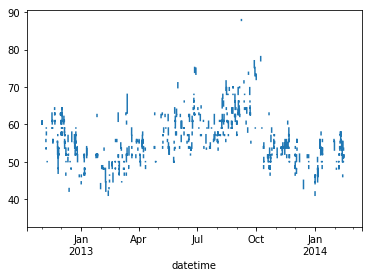

In [6]:
#If we want to use temperature as our exogenous variable, we need a complete timseries. We thus need to do some interpolation
df['temperature'].plot();

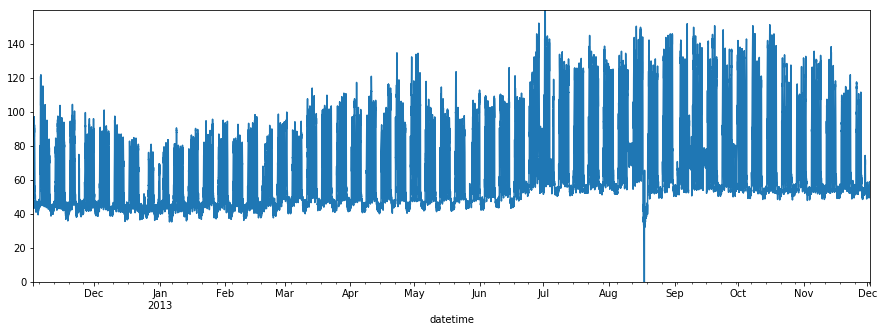

In [7]:
ax = df['power'].plot(figsize=(15,5))
ax.autoscale(tight=True)

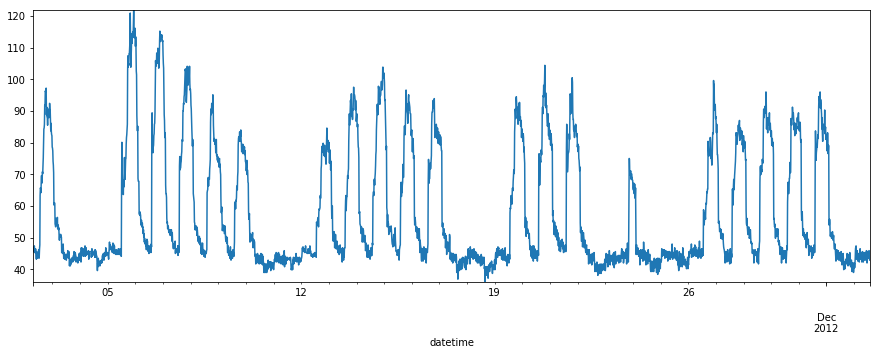

In [8]:
ax = df['power'][:3000].plot(figsize=(15,5))
ax.autoscale(tight=True)

We have a range of interesting seasonality present here. There are some missing values but they can probably be interpolated over. One option would be to remove all the NaNs and then train an ML model using the dataframe. Would have to design the test and train set approproately so that the model is not given any information about the future in the training set. An altnernative approach would be to interpolate and then train a SARIMAX model

In [9]:
df_ts = df.copy()

In [10]:
df_ts['temperature'] = df['temperature'].interpolate()
df_ts['power'] = df['power'].interpolate()

In [11]:
df_ts.isna().sum()/len(df_ts)

power          0.002022
temperature    0.000066
date           0.000000
time           0.000000
dow            0.000000
month          0.000000
dtype: float64

In [12]:
df_ts.dropna(inplace=True)

In [13]:
df_ts.head()

,power,temperature,date,time,dow,month
datetime,,,,,,
2012-11-02 07:15:00,45.6,55.675,2012-11-02,00:15:00,4,11
2012-11-02 07:30:00,45.9,55.450,2012-11-02,00:30:00,4,11
2012-11-02 07:45:00,46.8,55.225,2012-11-02,00:45:00,4,11
2012-11-02 08:00:00,45.9,55.000,2012-11-02,01:00:00,4,11
2012-11-02 08:15:00,47.4,54.750,2012-11-02,01:15:00,4,11


In [14]:
#Cut off to the final day in november
df_ts = df_ts[:'2013-11-30']

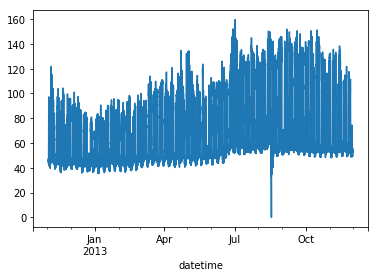

In [15]:
df_ts['power'].plot()

In [16]:
df_ts['power'].tail()

datetime
2013-11-30 22:45:00    52.5
2013-11-30 23:00:00    53.1
2013-11-30 23:15:00    53.4
2013-11-30 23:30:00    53.7
2013-11-30 23:45:00    53.7
Name: power, dtype: float64

In [17]:
np.mean(df_ts.index.to_series().diff()) #we know that the freq is a number of minutes 

Timedelta('0 days 00:15:00')

In [18]:
df_ts.index.freq = '15T'

In [19]:
df_ts.index #note that we have set the frequency here 

DatetimeIndex(['2012-11-02 07:15:00', '2012-11-02 07:30:00',
               '2012-11-02 07:45:00', '2012-11-02 08:00:00',
               '2012-11-02 08:15:00', '2012-11-02 08:30:00',
               '2012-11-02 08:45:00', '2012-11-02 09:00:00',
               '2012-11-02 09:15:00', '2012-11-02 09:30:00',
               ...
               '2013-11-30 21:30:00', '2013-11-30 21:45:00',
               '2013-11-30 22:00:00', '2013-11-30 22:15:00',
               '2013-11-30 22:30:00', '2013-11-30 22:45:00',
               '2013-11-30 23:00:00', '2013-11-30 23:15:00',
               '2013-11-30 23:30:00', '2013-11-30 23:45:00'],
              dtype='datetime64[ns]', name='datetime', length=37795, freq='15T')

In [20]:
df_ts['hour_of_day'] = df_ts.index.to_series().apply(lambda x: x.hour)

In [21]:
df_ts = df_ts.drop(columns=['date','time'],axis=1)

In [22]:
df_ts.head()

,power,temperature,dow,month,hour_of_day
datetime,,,,,
2012-11-02 07:15:00,45.6,55.675,4,11,7
2012-11-02 07:30:00,45.9,55.450,4,11,7
2012-11-02 07:45:00,46.8,55.225,4,11,7
2012-11-02 08:00:00,45.9,55.000,4,11,8
2012-11-02 08:15:00,47.4,54.750,4,11,8


### Seasonal decomposition and evaluation of seasonality

In [23]:
adf_test(df_ts['power'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -1.376319e+01
p-value                 9.996322e-26
# lags used             5.200000e+01
# observations          3.774200e+04
critical value (1%)    -3.430523e+00
critical value (5%)    -2.861617e+00
critical value (10%)   -2.566811e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [24]:
grangercausalitytests(df_ts[['power','temperature']],maxlag=3)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=26.6860 , p=0.0000  , df_denom=37791, df_num=1
ssr based chi2 test:   chi2=26.6881 , p=0.0000  , df=1
likelihood ratio test: chi2=26.6787 , p=0.0000  , df=1
parameter F test:         F=26.6860 , p=0.0000  , df_denom=37791, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=401.6853, p=0.0000  , df_denom=37788, df_num=2
ssr based chi2 test:   chi2=803.4768, p=0.0000  , df=2
likelihood ratio test: chi2=795.0550, p=0.0000  , df=2
parameter F test:         F=401.6853, p=0.0000  , df_denom=37788, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=306.4475, p=0.0000  , df_denom=37785, df_num=3
ssr based chi2 test:   chi2=919.5127, p=0.0000  , df=3
likelihood ratio test: chi2=908.5046, p=0.0000  , df=3
parameter F test:         F=306.4475, p=0.0000  , df_denom=37785, df_num=3


{1: ({'ssr_ftest': (26.685993057220024, 2.405637107674942e-07, 37791.0, 1),
   'ssr_chi2test': (26.6881114975675, 2.390880439705285e-07, 1),
   'lrtest': (26.678693069145083, 2.40256308399445e-07, 1),
   'params_ftest': (26.68599305722208, 2.4056371076690754e-07, 37791.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (401.6852518404657, 2.3924097555332432e-173, 37788.0, 2),
   'ssr_chi2test': (803.4768033665035, 3.366890407708954e-175, 2),
   'lrtest': (795.0550254155823, 2.269837811310245e-173, 2),
   'params_ftest': (401.6852518404554, 2.3924097555588098e-173, 37788.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (306.4474505269798, 1.3684041688313425e-196, 37785.0, 3),
   'ssr_chi2test': (919.512667750347, 5.182647118169249e-199, 3),
   'lrtest': (908.504591003526, 1.2656555905611735e-196, 3),
   'params_ftest': (306.44745052696874, 1.368404168857867e-196, 37785.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 

/Users/rmartinshort/anaconda/envs/Insight/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


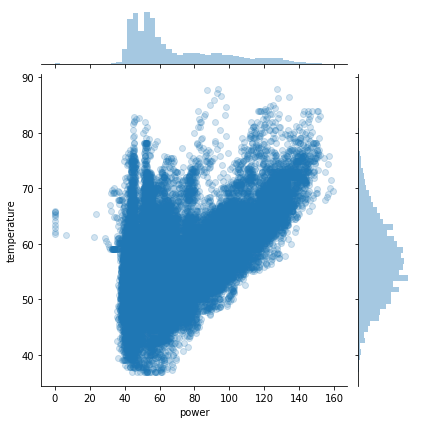

In [25]:
sns.jointplot(x='power',y='temperature',data=df_ts,kind='scatter',alpha=0.2);

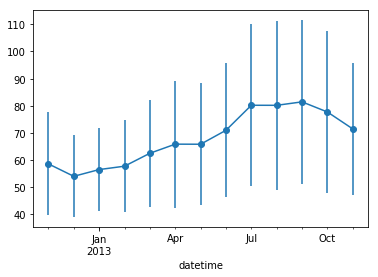

In [26]:
#mean over each month
power_std = df_ts['power'].resample(rule='M').std()
df_ts['power'].resample(rule='M').mean().plot(marker='o',yerr=power_std);

In [27]:
freq = 1/(15*60.) #frequency of sampling in hertz, since we have daily data
f, Pxx_den = welch(df_ts['power'], freq,nperseg=1024)

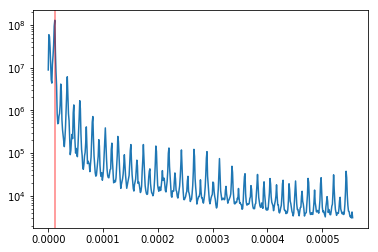

In [28]:
plt.semilogy(f,Pxx_den)
peak_freq = f[np.argmax(Pxx_den)]
plt.axvline(peak_freq,color='red',alpha=0.5)

In [29]:
(1/peak_freq)/(3600*24) #This means we have a peak seasonality of 1 day, which makes sense

0.9696969696969696

In [30]:
peak_freq

1.193576388888889e-05

In [31]:
intervals_in_day = int(24*60/15)

### Fitting a SARIMA

In [32]:
test_period = int(7*24*60/15) #number of 15 min intervals in a week

In [33]:
train = df_ts.iloc[:len(df_ts)-test_period]
test = df.iloc[len(df_ts)-test_period:]

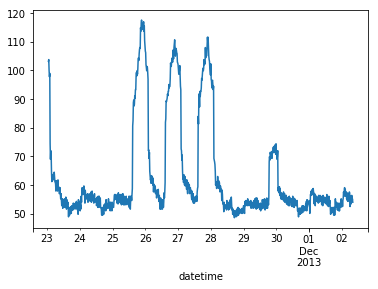

In [34]:
test['power'].plot()

## Running autoarima takes a really long time! 

This is likely because the data frequency is high. Lets resample to every hour to try to 
make things a little faster

In [35]:
df_hourly = df_ts.resample(rule='H').mean()

In [36]:
df_hourly.index

DatetimeIndex(['2012-11-02 07:00:00', '2012-11-02 08:00:00',
               '2012-11-02 09:00:00', '2012-11-02 10:00:00',
               '2012-11-02 11:00:00', '2012-11-02 12:00:00',
               '2012-11-02 13:00:00', '2012-11-02 14:00:00',
               '2012-11-02 15:00:00', '2012-11-02 16:00:00',
               ...
               '2013-11-30 14:00:00', '2013-11-30 15:00:00',
               '2013-11-30 16:00:00', '2013-11-30 17:00:00',
               '2013-11-30 18:00:00', '2013-11-30 19:00:00',
               '2013-11-30 20:00:00', '2013-11-30 21:00:00',
               '2013-11-30 22:00:00', '2013-11-30 23:00:00'],
              dtype='datetime64[ns]', name='datetime', length=9449, freq='H')

If we do a seasonal decomposition we see a daily cycle. This is much better than the 15 minute data that we were looking at earlier

In [37]:
seasonal_decomp = seasonal_decompose(df_hourly['power'])

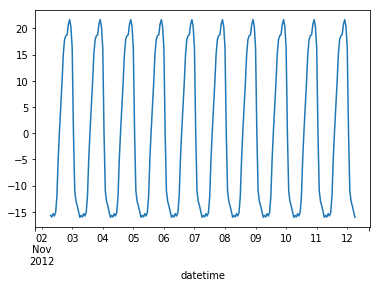

In [38]:
seasonal_decomp.seasonal.iloc[:240].plot();

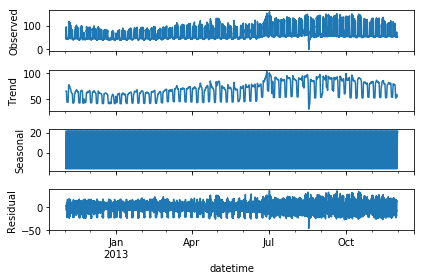

In [39]:
seasonal_decomp.plot();

### Lets hope that an autoarima here will take less time 

This still takes a really long time, which is a little surprising

In [ ]:
%%time
autoresult_sarimax = auto_arima(df_hourly['power'],exog=df_hourly[['temperature','month','dow','hour_of_day']],\
                                seasonal=True,m=24,trace=True,maxiter=10,solver='nm')

/Users/rmartinshort/anaconda/envs/Insight/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 0, 2) seasonal_order=(1, 1, 1, 24); AIC=56372.740, BIC=56429.949, Fit time=88.746 seconds


/Users/rmartinshort/anaconda/envs/Insight/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 1, 0, 24); AIC=83703.379, BIC=83717.681, Fit time=3.103 seconds


/Users/rmartinshort/anaconda/envs/Insight/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 1, 0, 24); AIC=60324.384, BIC=60352.988, Fit time=47.075 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 1, 1, 24); AIC=nan, BIC=nan, Fit time=nan seconds


/Users/rmartinshort/anaconda/envs/Insight/lib/python3.6/site-packages/pmdarima/arima/auto.py:870: ModelFitWarning: Unable to fit ARIMA for order=(0, 0, 1) seasonal_order=(0, 1, 1, 24); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
/Users/rmartinshort/anaconda/envs/Insight/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 0, 2) seasonal_order=(0, 1, 1, 24); AIC=57152.355, BIC=57202.413, Fit time=70.747 seconds


/Users/rmartinshort/anaconda/envs/Insight/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 0, 2) seasonal_order=(2, 1, 1, 24); AIC=56271.033, BIC=56335.393, Fit time=209.931 seconds


/Users/rmartinshort/anaconda/envs/Insight/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 0, 2) seasonal_order=(2, 1, 0, 24); AIC=58542.733, BIC=58599.942, Fit time=167.068 seconds


/Users/rmartinshort/anaconda/envs/Insight/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 0, 2) seasonal_order=(2, 1, 2, 24); AIC=56228.845, BIC=56300.356, Fit time=241.714 seconds


/Users/rmartinshort/anaconda/envs/Insight/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 0, 2) seasonal_order=(2, 1, 2, 24); AIC=56136.431, BIC=56200.791, Fit time=224.168 seconds


/Users/rmartinshort/anaconda/envs/Insight/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 0, 1) seasonal_order=(2, 1, 2, 24); AIC=56221.968, BIC=56279.177, Fit time=179.379 seconds


/Users/rmartinshort/anaconda/envs/Insight/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 0, 3) seasonal_order=(2, 1, 2, 24); AIC=56118.890, BIC=56190.401, Fit time=218.847 seconds
Fit ARIMA: order=(0, 0, 2) seasonal_order=(2, 1, 2, 24); AIC=nan, BIC=nan, Fit time=nan seconds


/Users/rmartinshort/anaconda/envs/Insight/lib/python3.6/site-packages/pmdarima/arima/auto.py:870: ModelFitWarning: Unable to fit ARIMA for order=(0, 0, 2) seasonal_order=(2, 1, 2, 24); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
/Users/rmartinshort/anaconda/envs/Insight/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 0, 4) seasonal_order=(2, 1, 2, 24); AIC=56091.041, BIC=56176.854, Fit time=361.624 seconds


/Users/rmartinshort/anaconda/envs/Insight/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 0, 4) seasonal_order=(1, 1, 2, 24); AIC=56200.115, BIC=56278.778, Fit time=366.183 seconds


/Users/rmartinshort/anaconda/envs/Insight/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


### Try fitting regualar ARIMA (without seasonality)

In [157]:
autoresult = auto_arima(df_hourly['power'],seasonal=False,trace=True)

Fit ARIMA: order=(2, 1, 2); AIC=63585.899, BIC=63628.820, Fit time=3.217 seconds
Fit ARIMA: order=(0, 1, 0); AIC=65565.172, BIC=65579.479, Fit time=0.079 seconds
Fit ARIMA: order=(1, 1, 0); AIC=63594.025, BIC=63615.486, Fit time=0.097 seconds


/Users/rmartinshort/anaconda/envs/Insight/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/Users/rmartinshort/anaconda/envs/Insight/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/Users/rmartinshort/anaconda/envs/Insight/lib/python3.6/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tupl

Fit ARIMA: order=(0, 1, 1); AIC=63850.800, BIC=63872.261, Fit time=0.072 seconds
Fit ARIMA: order=(1, 1, 2); AIC=63583.925, BIC=63619.693, Fit time=1.506 seconds
Fit ARIMA: order=(1, 1, 1); AIC=63595.584, BIC=63624.199, Fit time=1.321 seconds
Fit ARIMA: order=(1, 1, 3); AIC=63585.882, BIC=63628.803, Fit time=1.753 seconds
Fit ARIMA: order=(2, 1, 3); AIC=62107.076, BIC=62157.151, Fit time=3.956 seconds


/Users/rmartinshort/anaconda/envs/Insight/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 3); AIC=62946.716, BIC=63003.945, Fit time=11.648 seconds
Fit ARIMA: order=(2, 1, 4); AIC=62083.145, BIC=62140.373, Fit time=5.107 seconds
Fit ARIMA: order=(3, 1, 5); AIC=62961.667, BIC=63033.202, Fit time=8.093 seconds
Fit ARIMA: order=(1, 1, 4); AIC=63583.086, BIC=63633.161, Fit time=2.670 seconds


/Users/rmartinshort/anaconda/envs/Insight/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/rmartinshort/anaconda/envs/Insight/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 4); AIC=62116.079, BIC=62180.461, Fit time=18.402 seconds
Fit ARIMA: order=(2, 1, 5); AIC=63069.948, BIC=63134.330, Fit time=6.141 seconds
Total fit time: 64.097 seconds


In [158]:
autoresult.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                 9448
Model:                 ARIMA(2, 1, 4)   Log Likelihood              -31033.572
Method:                       css-mle   S.D. of innovations              6.460
Date:                Sat, 27 Apr 2019   AIC                          62083.145
Time:                        20:35:02   BIC                          62140.373
Sample:                             1   HQIC                         62102.571
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0017      0.039     -0.043      0.966      -0.078       0.075
ar.L1.D.y      1.9056      0.003    577.363      0.000       1.899       1.912
ar.L2.D.y     -0.9656      0.003   -283.886      0.000      -0.972      -0.959
ma.L1.D.y     -1.6391      0.012   -139.377      0.000      -1.662      -1.616
ma.L2.D.y      0.4259      0.019     22.316      0.000       0.388       0.463
ma.L3.D.y      0.3155      0.021     14.866      0.000       0.274       0.357
ma.L4.D.y     -0.0670      0.013     -5.062      0.000      -0.093      -0.041
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.9867           -0.2490j            1.0177           -0.0393
AR.2            0.9867           +0.2490j            1.0177            0.0393
MA.1            1.0564           -0.1813j            1.0719           -0.0270
MA.2            1.0564           +0.1813j            1.0719            0.0270
MA.3           -2.5330           -0.0000j            2.5330           -0.5000
MA.4            5.1301           -0.0000j            5.1301           -0.0000
-----------------------------------------------------------------------------
"""

In [159]:
autoresult = auto_arima(df_hourly['power'],exog=df_hourly[['temperature','dow','month','hour_of_day']],seasonal=False,trace=True)

Fit ARIMA: order=(2, 1, 2); AIC=63585.899, BIC=63628.820, Fit time=1.874 seconds
Fit ARIMA: order=(0, 1, 0); AIC=65565.172, BIC=65579.479, Fit time=0.009 seconds
Fit ARIMA: order=(1, 1, 0); AIC=63594.025, BIC=63615.486, Fit time=0.096 seconds
Fit ARIMA: order=(0, 1, 1); AIC=63850.800, BIC=63872.261, Fit time=0.061 seconds


/Users/rmartinshort/anaconda/envs/Insight/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/Users/rmartinshort/anaconda/envs/Insight/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/Users/rmartinshort/anaconda/envs/Insight/lib/python3.6/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tupl

Fit ARIMA: order=(1, 1, 2); AIC=63583.925, BIC=63619.693, Fit time=1.204 seconds
Fit ARIMA: order=(1, 1, 1); AIC=63595.584, BIC=63624.199, Fit time=1.064 seconds
Fit ARIMA: order=(1, 1, 3); AIC=63585.882, BIC=63628.803, Fit time=1.393 seconds
Fit ARIMA: order=(2, 1, 3); AIC=62107.076, BIC=62157.151, Fit time=2.991 seconds


/Users/rmartinshort/anaconda/envs/Insight/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 3); AIC=62946.716, BIC=63003.945, Fit time=8.219 seconds
Fit ARIMA: order=(2, 1, 4); AIC=62083.145, BIC=62140.373, Fit time=4.024 seconds
Fit ARIMA: order=(3, 1, 5); AIC=62961.667, BIC=63033.202, Fit time=5.923 seconds
Fit ARIMA: order=(1, 1, 4); AIC=63583.086, BIC=63633.161, Fit time=2.006 seconds


/Users/rmartinshort/anaconda/envs/Insight/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/rmartinshort/anaconda/envs/Insight/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 1, 4); AIC=62116.079, BIC=62180.461, Fit time=12.708 seconds
Fit ARIMA: order=(2, 1, 5); AIC=63069.948, BIC=63134.330, Fit time=6.472 seconds
Total fit time: 48.050 seconds


In [160]:
autoresult.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                 9448
Model:                 ARIMA(2, 1, 4)   Log Likelihood              -31033.572
Method:                       css-mle   S.D. of innovations              6.460
Date:                Sat, 27 Apr 2019   AIC                          62083.145
Time:                        20:37:16   BIC                          62140.373
Sample:                             1   HQIC                         62102.571
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0017      0.039     -0.043      0.966      -0.078       0.075
ar.L1.D.y      1.9056      0.003    577.363      0.000       1.899       1.912
ar.L2.D.y     -0.9656      0.003   -283.886      0.000      -0.972      -0.959
ma.L1.D.y     -1.6391      0.012   -139.377      0.000      -1.662      -1.616
ma.L2.D.y      0.4259      0.019     22.316      0.000       0.388       0.463
ma.L3.D.y      0.3155      0.021     14.866      0.000       0.274       0.357
ma.L4.D.y     -0.0670      0.013     -5.062      0.000      -0.093      -0.041
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.9867           -0.2490j            1.0177           -0.0393
AR.2            0.9867           +0.2490j            1.0177            0.0393
MA.1            1.0564           -0.1813j            1.0719           -0.0270
MA.2            1.0564           +0.1813j            1.0719            0.0270
MA.3           -2.5330           -0.0000j            2.5330           -0.5000
MA.4            5.1301           -0.0000j            5.1301           -0.0000
-----------------------------------------------------------------------------
"""

### Fit an ARIMA model with exogenous variables 

This works really well on the training data, but poorly on the test. We need to compare it to a seasonal model

In [62]:
test_period = 24*7
train = df_hourly.iloc[:len(df_hourly)-test_period]
test = df_hourly.iloc[len(df_hourly)-test_period:]

In [63]:
#Train the model
model = ARIMA(train['power'],exog=train[['temperature','dow','month','hour_of_day']],order=(2,1,4))

In [64]:
fitted_model = model.fit()

In [65]:
start = len(train)
end = start + len(test) - 1
predictions = fitted_model.predict(start=start,end=end,exog=test[['temperature','dow','month','hour_of_day']],typ='levels').rename('ARIMA predictions')

41.931831653255145

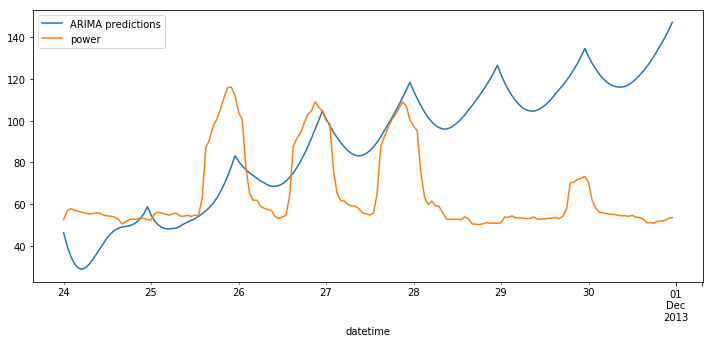

In [66]:
predictions.plot(legend=True,figsize=(12,5))
test['power'].plot(legend=True)

#report the rmse. This is pretty poor It would be interesing to try the SARIMAX again actually
rmse(test['power'],predictions)

### Fit SARIMAX. This will probably take a long time! 

It may also result in convergence errors

In [67]:
model_sarimax = SARIMAX(train['power'],exog=train[['temperature','dow','month','hour_of_day']],\
                order=(2,0,4),seasonal_order=(1, 1, 2, 24),maxiter=10)

In [68]:
fitted_model_sarimax = model_sarimax.fit()

/Users/rmartinshort/anaconda/envs/Insight/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [69]:
start = len(train)
end = start + len(test) - 1
predictions_sarimax = fitted_model_sarimax.predict(start=start,end=end,exog=test[['temperature','dow','month','hour_of_day']],typ='levels').rename('SARIMAX predictions')

RMSE ARIMAX: 41.931832
RMSE SARIMAX: 17.536838


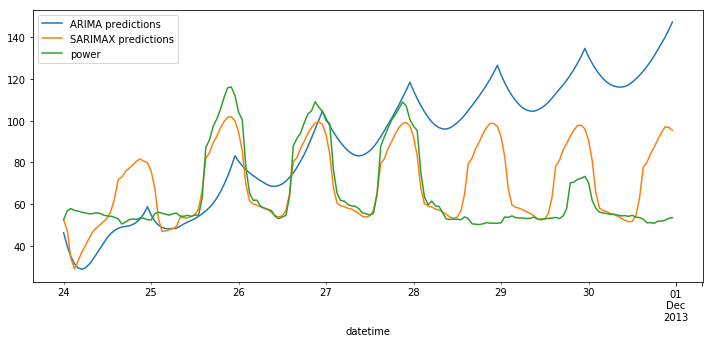

In [70]:
predictions.plot(legend=True,figsize=(12,5))
predictions_sarimax.plot(legend=True)
test['power'].plot(legend=True)

#report the rmse for the two models
print('RMSE ARIMAX: %f' %rmse(test['power'],predictions))
print('RMSE SARIMAX: %f' %rmse(test['power'],predictions_sarimax))

In [ ]:
fitted_model_full = ARIMA(df_hourly['power'],exog=df_hourly[['temperature','dow','month','hour_of_day']],order=(2,1,4))

In [60]:
sarimax_forecast = fitted_model.predict(start=len(df_hourly),end=len(df_hourly)+(7*24),\
                exog=df_hourly[['temperature','dow','month','hour_of_day']],typ='levels')

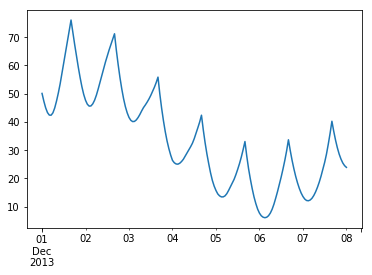

In [61]:
sarimax_forecast.plot()

### Using a random forest

This is certainly easier and faster, plus it can be trained on the full dataset

In [83]:
test_period = int(7*24*60/15) #number of 15 min intervals in a week
train_df = df_ts.iloc[:len(df_ts)-test_period]
test_df = df_ts.iloc[len(df_ts)-test_period:]

In [84]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [104]:
X_train = train_df.drop('power',axis=1)
y_train = train_df['power']


#Technically we should write our own CV code here that actually does the train-test split in 
#the way that we would want, not randomly. However, this should give us a decent model that we 
#apply to the testing dataset

parameters = {'n_estimators':(1,100,500),'min_samples_leaf':(1,5,10,50)}
#model = RandomForestRegressor(n_estimators=100,min_samples_leaf=1,n_jobs=4)
clf = GridSearchCV(model, parameters)
clf.fit(X_train,y_train)

#model.fit(X_train,y_train)

/Users/rmartinshort/anaconda/envs/Insight/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=4,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': (1, 100, 500), 'min_samples_leaf': (1, 5, 10, 50)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [86]:
X_test = test_df.drop('power',axis=1)
y_test = test_df['power']

In [105]:
model = clf.best_estimator_

In [106]:
predictions = model.predict(X_test)

In [118]:
rf_predictions = pd.DataFrame({'predicted_power_RF':predictions})

In [119]:
rf_predictions.index = y_test.index

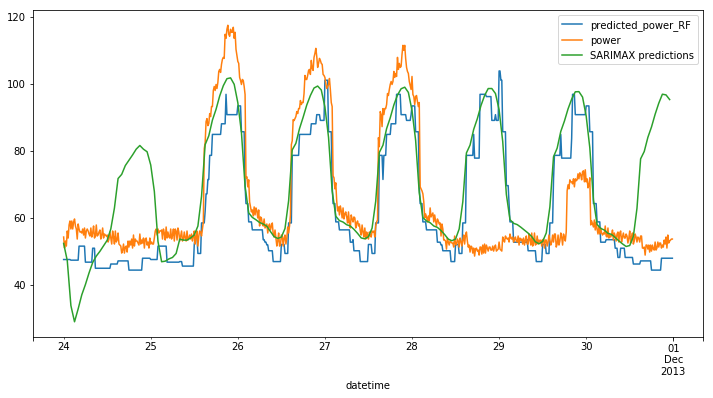

In [121]:
rf_predictions.plot(figsize=(12,6))
y_test.plot(legend=True)
predictions_sarimax.plot(legend=True)

The SARIMAX is smoothed but looks more accurate on weekdays at least. The RF does better on weekends, but its possible that the SARIMAX could be adapted to account for the weekend and public holidays, when the energy useage is much lower

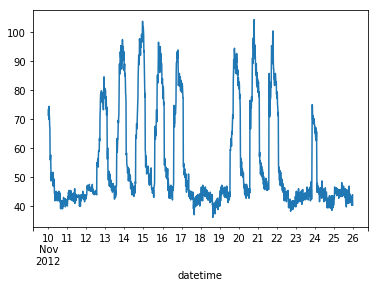

In [116]:
y_train['2012-11-10':'2012-11-25'].plot()

There are other things that we could consider here, like whether or not a day is a public holiday